In [1]:
import torch
# torch.compile 是 PyTorch 2.0 引入的一个功能，旨在通过将模型编译为更高效的执行形式来提高模型的性能。这个功能利用了 PyTorch 的 JIT（Just-In-Time）编译器和其他优化技术，使得模型在推理和训练时更快

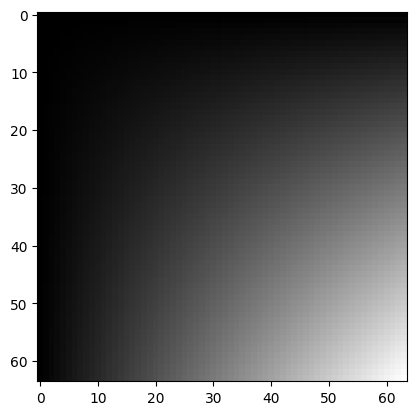

In [2]:
# 示例：将 PIL 的 crop 包装到自定义运算符中

import torch
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import PIL
import IPython
import matplotlib.pyplot as plt

def crop(pic, box):
    img = to_pil_image(pic.cpu())
    cropped_img = img.crop(box)
    return pil_to_tensor(cropped_img).to(pic.device) / 255.

def display(img):
    plt.imshow(img.numpy().transpose((1, 2, 0)))

img = torch.ones(3, 64, 64)
img *= torch.linspace(0, 1, steps=64) * torch.linspace(0, 1, steps=64).unsqueeze(-1)
display(img)


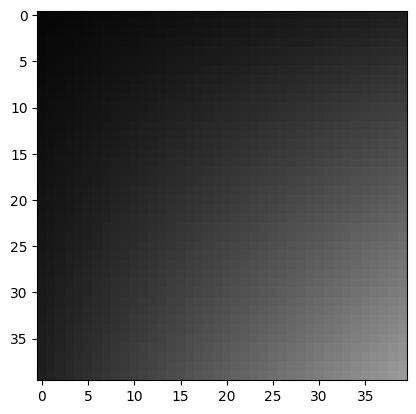

In [3]:
cropped_img = crop(img, (10, 10, 50, 50))
display(cropped_img)

In [4]:
# torch.compile会导致 无法处理的函数出现“计算图中断“ ，而图形中断对性能不利。以下代码通过引发错误
@torch.compile(fullgraph=True)
def f(img):
    return crop(img, (10, 10, 50, 50))

# The following raises an error. Uncomment the line to see it.
# cropped_img = f(img)

In [5]:
# 为了在torch.compile中使用黑盒裁剪，我们需要做两件事：
    # 将函数包装成PyTorch自定义操作符。
    # 添加一个“FakeTensor kernel”（又名“meta kernel”）到操作符。给定一些FakeTensors输入（虚拟张量没有存储），这个函数应该返回你选择的虚拟张量与正确的张量元数据（形状/strides/dtype/设备）。
from typing import Sequence

# Use torch.library.custom_op to define a new custom operator.
# If your operator mutates any input Tensors, their names must be specified
# in the ``mutates_args`` argument.
@torch.library.custom_op("mylib::crop", mutates_args=())
def crop(pic: torch.Tensor, box: Sequence[int]) -> torch.Tensor:
    img = to_pil_image(pic.cpu())
    cropped_img = img.crop(box)
    return (pil_to_tensor(cropped_img) / 255.).to(pic.device, pic.dtype)

# Use register_fake to add a ``FakeTensor`` kernel for the operator
@crop.register_fake
def _(pic, box):
    channels = pic.shape[0]
    x0, y0, x1, y1 = box
    return pic.new_empty(channels, y1 - y0, x1 - x0)

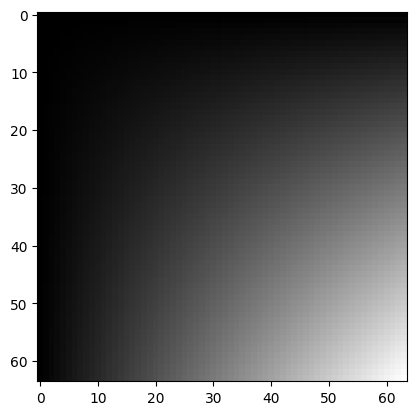

In [6]:
@torch.compile(fullgraph=True)
def f(img):
    return crop(img, (10, 10, 50, 50))

cropped_img = f(img)
display(img)

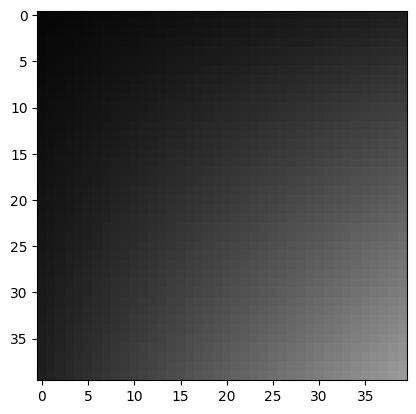

In [7]:
display(cropped_img)

In [8]:
# 增加梯度
# crop的梯度公式本质上是PIL.paste（我们将推导过程留给读者作为练习）
@torch.library.custom_op("mylib::paste", mutates_args=())
def paste(im1: torch.Tensor, im2: torch.Tensor, coord: Sequence[int]) -> torch.Tensor:
    assert im1.device == im2.device
    assert im1.dtype == im2.dtype
    im1_pil = to_pil_image(im1.cpu())
    im2_pil = to_pil_image(im2.cpu())
    PIL.Image.Image.paste(im1_pil, im2_pil, coord)
    return (pil_to_tensor(im1_pil) / 255.).to(im1.device, im1.dtype)

@paste.register_fake
def _(im1, im2, coord):
    assert im1.device == im2.device
    assert im1.dtype == im2.dtype
    return torch.empty_like(im1)

def backward(ctx, grad_output):
    grad_input = grad_output.new_zeros(ctx.pic_shape)
    grad_input = paste(grad_input, grad_output, ctx.coords)
    return grad_input, None

def setup_context(ctx, inputs, output):
    pic, box = inputs
    ctx.coords = box[:2]
    ctx.pic_shape = pic.shape

crop.register_autograd(backward, setup_context=setup_context)
# 请注意，后向必须是 PyTorch 理解的运算符的组合，这就是为什么我们将 paste 包装到自定义运算符中而不是直接使用 PIL 的 paste。

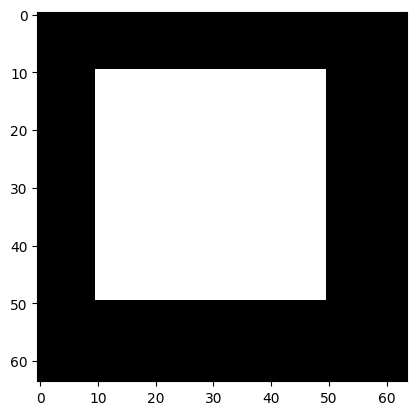

In [9]:
img = img.requires_grad_()
result = crop(img, (10, 10, 50, 50))
result.sum().backward()
display(img.grad)

In [10]:
# 用于torch.library.opcheck测试自定义运算符是否已正确注册。这不会测试梯度在数学上是否正确；请为此编写单独的测试（手动测试或torch.autograd.gradcheck）。
examples = [
    [torch.randn(3, 64, 64), [0, 0, 10, 10]],
    [torch.randn(3, 91, 91, requires_grad=True), [10, 0, 20, 10]],
    [torch.randn(3, 60, 60, dtype=torch.double), [3, 4, 32, 20]],
    [torch.randn(3, 512, 512, requires_grad=True, dtype=torch.double), [3, 4, 32, 45]],
]

for example in examples:
    torch.library.opcheck(crop, example)

In [11]:
# 可改变输入的 Python 自定义运算符
# 您还可以将一个可改变其输入的 Python 函数包装为自定义运算符。改变输入的函数很常见，因为这就是许多低级内核的编写方式；例如，计算内核sin可能会接收输入和输出张量，并写入input.sin()输出张量。
import numpy as np

@torch.library.custom_op("mylib::numpy_sin", mutates_args={"output"}, device_types="cpu")
def numpy_sin(input: torch.Tensor, output: torch.Tensor) -> None:
    assert input.device == output.device
    assert input.device.type == "cpu"
    input_np = input.numpy()
    output_np = output.numpy()
    np.sin(input_np, out=output_np)
# 因为操作符不返回任何东西，所以不需要注册FakeTensor内核
@torch.compile(fullgraph=True)
def f(x):
    out = torch.empty(3)
    numpy_sin(x, out)
    return out

x = torch.randn(3)
y = f(x)
assert torch.allclose(y, x.sin())

In [12]:
example_inputs = [
    [torch.randn(3), torch.empty(3)],
    [torch.randn(0, 3), torch.empty(0, 3)],
    [torch.randn(1, 2, 3, 4, dtype=torch.double), torch.empty(1, 2, 3, 4, dtype=torch.double)],
]

for example in example_inputs:
    torch.library.opcheck(numpy_sin, example)

In [13]:
torch.library.custom_op

<function torch.library.custom_op(name: str, fn: Optional[Callable] = None, /, *, mutates_args: Iterable[str], device_types: Union[str, Sequence[str], NoneType] = None, schema: Optional[str] = None) -> Callable>